In [82]:
import numpy as np
import sys
sys.path.append("../")
import rms_torch 

In [16]:
L = 6
s = 3 

N = 3 ** L

x = np.random.rand(N).reshape(L * (s,))
y = np.zeros_like(x)
for i in range(L):
    y += x
    x = np.transpose(x)
y /= np.linalg.norm(y)
y = y.reshape(-1)

In [19]:
rho = y[:, None] @ y[None, :]

In [20]:
rho_ = rho.reshape(s**2, s**(L-2), s**2, s**(L-2))
prho = np.einsum("jiki->jk", rho_)

In [24]:
e, v = np.linalg.eigh(prho)

## Above procedure doesn't have kernel

In [14]:
import tensornetwork as tn
import numpy as np
from matplotlib import pyplot as plt
import copy 

In [19]:
# Retrieving a component

def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return np.random.random_sample(size)

def create_MPS(rank, dimension, bond_dimension):
    '''Build the MPS tensor'''
    A = block(bond_dim, dim, bond_dim)
    mps =  [ tn.Node( np.copy(A) ) for _ in range(rank)] 
    #connect edges to build mps
    connected_edges=[]
    for k in range(0,rank):
        conn=mps[k][2]^mps[(k+1)%rank][0]
        connected_edges.append(conn)

    return mps, connected_edges

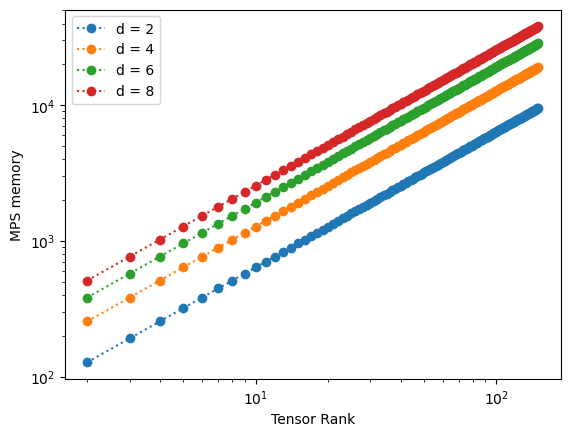

In [20]:
dimensions = range(2,9,2)
MPS_ranks = range(2,150)
MPS_memory = []

for dim in dimensions:
    bond_dim = 2
    MPS_memory = []
    for i in range(len(MPS_ranks)):
        rank = MPS_ranks[i]

        # Creating the MPS state:
        ##################################################################
        mps_nodes, mps_edges = create_MPS(rank, dim, bond_dim)
        MPS_memory.append(np.sum([x.tensor.nbytes for x in mps_nodes]))

    # Plot Results
    plt.loglog(MPS_ranks, MPS_memory, 'o',ls=':', label = f'd = {dim}')

plt.legend()
plt.xlabel('Tensor Rank')
plt.ylabel('MPS memory')

plt.show()

In [51]:
########################################################################
#----- Retrieving a Component from an MPS by Contracting its edges-----#
########################################################################
dim = s =  3
bond_dim = 2
rank = L =  6
components=tuple(np.random.randint(0, dim, rank)) #select randomly the components that we will retrieve
print(f'components are: {components}')

mps_nodes, mps_edges = create_MPS(rank, dim, bond_dim)
for k in range(len(mps_edges)):
    A = tn.contract(mps_edges[k])

#the last node now has all the edges corresponding to the tensor components.

print(f'coefficient of the tensor at the selected components: {A.tensor[components]}')

components are: (2, 1, 0, 2, 0, 2)
coefficient of the tensor at the selected components: 0.5770874705424862


In [52]:
y = A.tensor.reshape(-1)

In [53]:
rho = y[:, None] @ y[None, :]

In [54]:
rho_ = rho.reshape(s**2, s**(L-2), s**2, s**(L-2))
prho = np.einsum("jiki->jk", rho_)

In [84]:
e, V = np.linalg.eigh(prho)
e = np.round(e, 10)
P = np.diagflat((e == 0)).astype(np.float64)
vp = V @ P 
h = vp @ vp.T
bonds = [[i, (i+1)%L] for i in range(L)]
H = rms_torch.sum_ham(h, bonds, L, s)